<a href="https://colab.research.google.com/github/A01793891/Equipo_76/blob/main/Arboldedecision_Equipo37.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Inteligencia Artificial y Aprendizaje Automático**
###Tecnológico de Monterrey
###Prof Luis Eduardo Falcón Morales

## **Actividad de la Semana 6**
###**Árboles de decisión y bosque aleatorio.**

**Nombres y matrículas de los integrantes del equipo:**

* Alejandro Bautista Ramos - A00973450
* José Daniel Camacho Torres - A01793555
* Adriana Camarillo Durán - A01551139
* Andrei García Torres - A01793891
* Juan Carlos Villamil Rojas - A01794003

In [ ]:
import numpy as np
import codecs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, learning_curve, validation_curve, cross_validate, RepeatedStratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler


from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer

from sklearn import tree
import pydotplus 
from IPython.display import Image

## Inciso 1: Cargar datos



In [ ]:
x = np.genfromtxt("SouthGermanCredit.asc", dtype=None, encoding='utf-8-sig')

### Renombrar columnas

In [ ]:
df_input = pd.DataFrame(x, columns = ['status','duration','credit_history', 'purpose', 'amount', 'savings', 'employment_duration', 'installment_rate', 'personal_status_sex', 'other_debtors', 'present_residence', 'property', 'age', 'other_installment_plans', 'housing', 'number_credits', 'job', 'people_liable', 'telephone', 'foreign_worker', 'credit_risk' ])

### Define los datos de entrada y salida

In [ ]:
y_credit_approval = df_input['credit_risk']

In [ ]:
# Descartamos la fila 1 porque no nos sirve para el análisis
y_credit_approval = y_credit_approval[1:]

In [ ]:
# Descartamos la última columna porque esa será nuestra columna de output
df_input_drop = df_input.drop('credit_risk', axis='columns')

In [ ]:
# Descartamos la fila 1 porque no nos sirve para el análisis
df_input_drop_clean = df_input_drop[1:]

## Inciso 2: Clasificar en training y validation

In [ ]:
# Se hace una partición de los datos: 85% para el conjunto de entrenamiento y 15% para el conjunto de prueba
X_train, X_val, y_train, y_val = train_test_split(df_input_drop_clean, y_credit_approval, train_size=0.85)

In [ ]:
# Necesito saber cuáles son los mínimos y máximos valores en la columna amount
df_valores_numericos = pd.to_numeric(df_input_drop_clean['amount'])
print(f'Valor mínimo para los valores numéricos: {df_valores_numericos.min()}')
print(f'Valor máximo para los valores numéricos: {df_valores_numericos.max()}')

Valor mínimo para los valores numéricos: 250
Valor máximo para los valores numéricos: 18424


## Inciso 3: Configuración de pipelines

In [ ]:
vars_categoricas = pd.DataFrame()
vars_discretized_quantitative = pd.DataFrame()
vars_quantitative = pd.DataFrame()
vars_binaria = pd.DataFrame()

# one hot encoding
vars_binaria = ['foreign_worker','telephone']

# one hot encoding
vars_categoricas = ['job','housing','other_installment_plans','property','other_debtors','purpose','credit_history','personal_status_sex']

# scale
vars_quantitative = ['age','amount']
vars_discretized_quantitative = ['status','savings','employment_duration','installment_rate','status','present_residence','number_credits','people_liable']

In [ ]:
# imputar todas

# binarias - moda
# categoricas - moda
# quantitative - promedio
# discretized_quantitative - moda

binaries_categ_discretquant_pipeline = Pipeline(steps = [('imputar', SimpleImputer(strategy='most_frequent'))]) 

quantitative_pipeline = Pipeline(steps = [('imputar', SimpleImputer(strategy='mean')),
                                          ('scalar', MinMaxScaler(feature_range=(250, 18450)))]) 

catOHE_pipeline = Pipeline(steps = [('OneHotE', OneHotEncoder(handle_unknown = 'ignore'))])

encoder = OneHotEncoder()
encoder.fit(pd.concat([X_train['job'], X_train['housing'], X_train['other_installment_plans'], 
                              X_train['property'], X_train['other_debtors'], X_train['purpose'],
                              X_train['credit_history'], X_train['personal_status_sex']], axis=1))

OneHotEncoder()

In [ ]:
encoder.get_feature_names_out()

array(['job_1', 'job_2', 'job_3', 'job_4', 'housing_1', 'housing_2',
       'housing_3', 'other_installment_plans_1',
       'other_installment_plans_2', 'other_installment_plans_3',
       'property_1', 'property_2', 'property_3', 'property_4',
       'other_debtors_1', 'other_debtors_2', 'other_debtors_3',
       'purpose_0', 'purpose_1', 'purpose_10', 'purpose_2', 'purpose_3',
       'purpose_4', 'purpose_5', 'purpose_6', 'purpose_8', 'purpose_9',
       'credit_history_0', 'credit_history_1', 'credit_history_2',
       'credit_history_3', 'credit_history_4', 'personal_status_sex_1',
       'personal_status_sex_2', 'personal_status_sex_3',
       'personal_status_sex_4'], dtype=object)

In [ ]:
# Conjuntamos las transformaciones numéricas y categóricas que se estarán aplicando a los datos de entrada:
columnasTransformer = ColumnTransformer(transformers = [('num', quantitative_pipeline, vars_quantitative),
                                                        ('cat', binaries_categ_discretquant_pipeline, vars_categoricas),
                                                        ('catohe', catOHE_pipeline, vars_categoricas + vars_binaria)],
                                                        remainder='passthrough')

¿Por qué una variable binaria requeriría que se le aplique la transformación one-hot encoding?

Es necesario para que los modelos tomen el valor binario '1' como el de mayor valor para todas las variables categoricas y binarias del conujunto de datos. Este tipo de transformación nos ayuda a evitar que el modelo considere una jerarquía en variables categóricas o binarias, lo cual es muy útil para darle la misma importancia a los valores de todas las categorías.

## Inciso 4: Validación cruzada

In [ ]:
# Definimos funciones accuracy, precision, recall, f1-score y Gmean para calculo de metricas
def my_accuracy(yreal, ypred):
  vn, fp, fn, vp = confusion_matrix(yreal, ypred).ravel()
  tot = confusion_matrix(yreal, ypred).sum()
  return (vp+vn)/tot

def my_recall(yreal, ypred):
  vn, fp, fn, vp = confusion_matrix(yreal, ypred).ravel()
  return vp/(vp+fn)

def my_gmean(yreal, ypred):
  vn, fp, fn, vp = confusion_matrix(yreal, ypred).ravel()
  especificidad = vn / (vn+fp)
  recall = my_recall(yreal, ypred)
  return np.sqrt(recall*especificidad)

def my_precision(yreal, ypred):
  vn, fp, fn, vp = confusion_matrix(yreal, ypred).ravel()
  return vp/(vp+fp)

def my_f1_score(yreal, ypred):
  vn, fp, fn, vp = confusion_matrix(yreal, ypred).ravel()
  return (2*vp)/(2*vp+fp+fn)

In [ ]:
def obtain_cross_validate_scores(models, model_names, X, y, cv):
    scores = []
    for i in range(len(models)):
        cv_pipe = Pipeline(steps = 
          [
            ('Transformacion columnas', columnasTransformer),
            (model_names[i], models[i])
          ]
        )
        score = cross_validate(
            estimator=cv_pipe, X=X_train, y=y_train.values.ravel(),
            scoring={
                'accuracy':make_scorer(my_accuracy), 
                'recall':make_scorer(my_recall),
                'gmean':make_scorer(my_gmean), 
                'f1score':make_scorer(my_f1_score),
                'precision':make_scorer(my_precision)},
                cv = cv)
        scores.append(score)
        print('%s:\nmean Accuracy: %.3f (%.4f)\nmean Recall: %.3f (%.4f)\nGmean: %.3f (%.4f)\n mean F1 score: %.3f (%.4f)\n mean Precision: %.3f (%.4f)\n' % 
                  (model_names[i],
                   np.mean(score['test_accuracy']),
                   np.std(score['test_accuracy']), 
                   np.mean(score['test_recall']),
                   np.std(score['test_recall']),
                   np.mean(score['test_gmean']),
                   np.std(score['test_gmean']),
                   np.mean(score['test_f1score']),
                   np.std(score['test_f1score']),
                   np.mean(score['test_precision']),
                   np.std(score['test_precision']),
                  ))

    return scores

LogisticRegression:
mean Accuracy: 0.768 (0.0265)
mean Recall: 0.881 (0.0268)
Gmean: 0.668 (0.0410)
 mean F1 score: 0.841 (0.0187)
 mean Precision: 0.805 (0.0205)

DecisionTree:
mean Accuracy: 0.682 (0.0303)
mean Recall: 0.763 (0.0413)
Gmean: 0.610 (0.0543)
 mean F1 score: 0.770 (0.0229)
 mean Precision: 0.778 (0.0300)

RandomForest:
mean Accuracy: 0.754 (0.0211)
mean Recall: 0.908 (0.0271)
Gmean: 0.597 (0.0525)
 mean F1 score: 0.837 (0.0140)
 mean Precision: 0.777 (0.0181)



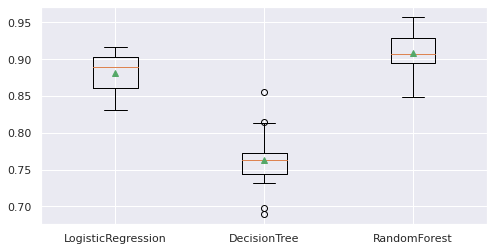

In [ ]:
models = [LogisticRegression(random_state=1, max_iter=3000), 
          DecisionTreeClassifier(random_state=1), 
          RandomForestClassifier(random_state=1)]

model_names= ['LogisticRegression', 'DecisionTree','RandomForest']

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

resultados = obtain_cross_validate_scores(models, model_names, X_train, y_train, cv)

sns.set(rc={'figure.figsize':(8,4)})
bpRecall = list()
for i in range(len(resultados)):
  rr = resultados[i]['test_recall']
  bpRecall.append(rr)

plt.boxplot(bpRecall, labels = model_names, showmeans=True)
plt.show()


¿Alguno de los modelos está subentrenado o sobreentrenado?

Los modelos de Logistic Regression, Decision Tree y Random Forest tienden a ser sub entrenados debido al amplio sesgo que muestran los resultados de las métricas con respecto a la media. Y podemos agregar que la varianza es baja de acuerdo a los resultados obtenidos.


In [ ]:
def mi_LearningCurvePlot(train_sizes, train_scores, val_scores):

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(7,6))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.1, color='blue')
    
    plt.plot(train_sizes, val_mean, color='red', marker='+', markersize=5, linestyle='--', label='Validation')
    plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.1, color='red')
    
    plt.title('Curvas de Aprendizaje incrementando el tamaño de la muestra')
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('F1 score')
    plt.grid()
    plt.legend(loc='lower left')
    plt.show()


In [ ]:
def mi_ModeloYCurvas(X_input, Y_output, my_score ):
  for i in range(3):
    mi_pipe = Pipeline(steps = [('columnas_transformadas', columnasTransformer),(model_names[i], models[i])])
    delta_train_sz = np.linspace(0.1, 1.0, 20)
    print(model_names[i])
    tr_sizes, tr_scores, val_scores = learning_curve(estimator = mi_pipe ,    
                                                    X = X_input,
                                                    y = Y_output,
                                                    cv = cv ,
                                                    train_sizes = delta_train_sz,
                                                    random_state=11, scoring= make_scorer(my_score))

    mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)


Curvas de aprendizaje del modelo lineal:
LogisticRegression


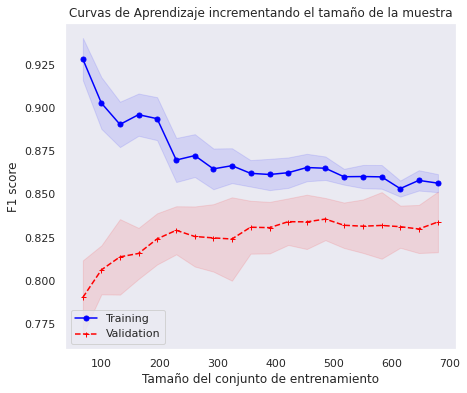

DecisionTree


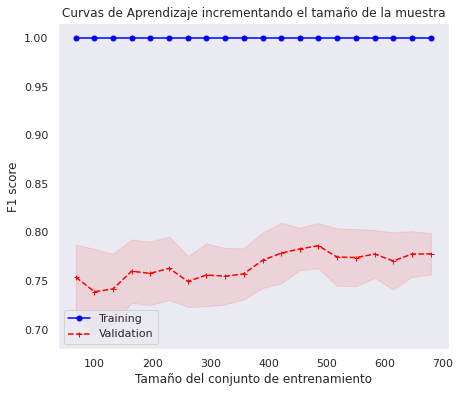

RandomForest


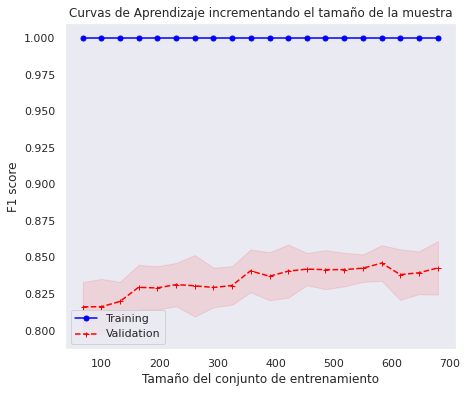

In [ ]:
print('Curvas de aprendizaje del modelo lineal:')
mi_ModeloYCurvas(X_train, y_train, my_f1_score)

Logistic Regression:

La curva de aprendizaje para este modelo tiene un comportamiento esperado y no está sobre entrenado. Se puede apreciar un sesgo considerable y una pequeña varianza.

Decision Tree:

En este modelo se puede apreciar sobre entrenamiento de las clasificaciones, debido a que tiene una máxima profundidad de clasificación.

Random Forest:

En este modelo se puede apreciar sobre entrenamiento de las clasificaciones. Esto se debe a que los árboles del bosque también están llegando a una profundidad máxima y no están podados.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_input_drop_clean, y_credit_approval, train_size=0.85)

In [ ]:
def mi_ModeloYCurvas_Validacion(X_set, y_set, metric, model_name, model):
    delta_C = np.linspace(1.0, 20.0, 20)
    X_val_transf = columnasTransformer.fit_transform(X_set)
    train_scores, valid_scores = validation_curve(model,    
                                                    X = X_val_transf,
                                                    y = y_set,
                                                    param_name="max_depth",
                                                    param_range=delta_C,
                                                    cv = cv ,
                                                    scoring= make_scorer(metric))

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    plt.plot(delta_C, train_mean, color='blue', marker='o', markersize=5, label='Training')

    # Curva de validación:
    plt.plot(delta_C, valid_mean, color='red', marker='o', markersize=5, label='Validation')

    plt.title('Función validation_curve() para ' + str(model_name))
    plt.xlabel('Valores del parámetro max_depth')
    plt.ylabel('Recall')
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()
    

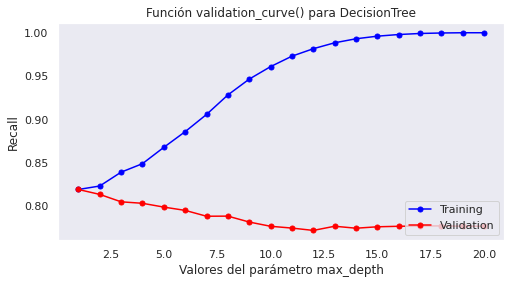

In [ ]:
# Decision Tree
mi_ModeloYCurvas_Validacion(X_train, y_train, my_f1_score, model_names[1], models[1]) 

## Inciso 5: Grid Search

Para el modelo de regresión logística realizar el entrenamiento buscando sus mejores hiperparámetros con GridSearchCV(). Los hiperparámetros que debes incluir en su búsqueda deben ser al menos los siguientes: C, solver, class_weight y penalty. En este caso deberás usar la métrica (scoring) “f1-score”. Imprime la mejor combinación de parámetros obtenidos, así como el valor del mejor desempeño (score) obtenido con la métrica f1. ¿Cuál es la utilidad de la métrica “f1-score”? Incluye tus conclusiones.
NOTA: Toma en cuenta que no todas las combinaciones de “solver” y “penalty” son posibles, para que lo tomes en cuenta al momento de realizar la búsqueda. Revisa la documentación.

In [ ]:
# Regresión logística:

dicc_grid = {'C':[1.0, 10.0, 100.0],
             'solver':['saga', 'liblinear'],
             'class_weight': ['balanced'],
             'penalty': ['l1', 'l2']
             }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=8)

grid = GridSearchCV(estimator=models[0], 
                    param_grid=dicc_grid, 
                    cv=cv, 
                    scoring=make_scorer(my_f1_score))

Xx = columnasTransformer.fit_transform(X_train)

# Llevamos a cabo el proceso de etrenamiento con validación-cruzada y búsqueda de malla.
# Observa que de acuerdo a las opciones incluidas en la malla, se estarán realizando (6)(5)=30 
# combinaciones diferentes, además de las (10)(5)=50 particiones de la validación-cruzada,
# lo cual implica también un mayor tiempo de entrenamiento.

grid.fit(Xx, np.ravel(y_train))


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=8),
             estimator=LogisticRegression(max_iter=3000, random_state=1),
             param_grid={'C': [1.0, 10.0, 100.0], 'class_weight': ['balanced'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['saga', 'liblinear']},
             scoring=make_scorer(my_f1_score))

In [ ]:
print('Mejor valor de F1 Score obtenido con la mejor combinación:', grid.best_score_)
print('Mejor combinación de valores encontrados de los hiperparámetros:', grid.best_params_)
print('Métrica utilizada:', grid.scoring)

Mejor valor de F1 Score obtenido con la mejor combinación: 0.7839555644129661
Mejor combinación de valores encontrados de los hiperparámetros: {'C': 1.0, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Métrica utilizada: make_scorer(my_f1_score)


In [ ]:
def mi_CurvasHiperparametros(X_input, Y_output, my_score):
  mi_pipe = Pipeline(steps = [('columnas_transformadas', columnasTransformer),(model_names[0],LogisticRegression(penalty='l2', C=10, class_weight='balanced', solver='liblinear'))])
  delta_train_sz = np.linspace(0.1, 1.0, 20)
  print(model_names[0])
  tr_sizes, tr_scores, val_scores = learning_curve(estimator = mi_pipe ,    
                                                  X = X_input,
                                                  y = Y_output,
                                                  cv = cv ,
                                                  train_sizes = delta_train_sz,
                                                  random_state=11, scoring= make_scorer(my_score))

  mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)

LogisticRegression


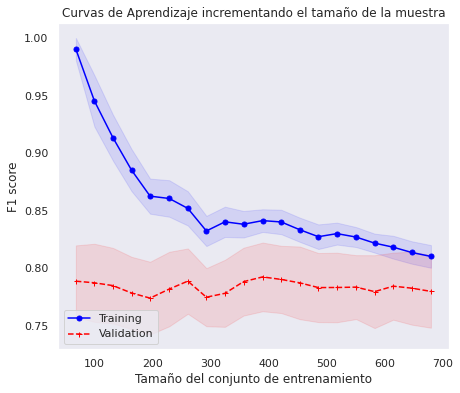

In [ ]:
mi_CurvasHiperparametros(X_train, y_train, my_f1_score)

Para el modelo de árbol de decisión (decision tree) realizar el entrenamiento buscando sus mejores hiperparámetros con GridSearchCV(). Los hiperparámetros que debes incluir en su búsqueda deben ser al menos los siguientes: ccp_alpha, criterion, max_depth, min_samples_split y class_weight. En este caso deberás usar la métrica (scoring) “precision”. Imprime la mejor combinación de parámetros obtenidos, así como el valor del mejor desempeño (score) obtenido con la métrica “precision”. ¿Cuál es la utilidad de la métrica “precision”? Incluye tus conclusiones.

In [ ]:
# Arbol:

dicc_grid_arbol = {'ccp_alpha':[0.0],
             'criterion':['entropy', 'gini'],
             'max_depth': [5, 10],
             'min_samples_split': [2,4],
             'class_weight': ['balanced']
             }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=8)

grid = GridSearchCV(estimator=models[1], 
                    param_grid=dicc_grid_arbol, 
                    cv=cv, 
                    scoring=make_scorer(my_precision))

Xx = columnasTransformer.fit_transform(X_train)

# Llevamos a cabo el proceso de etrenamiento con validación-cruzada y búsqueda de malla.
# Observa que de acuerdo a las opciones incluidas en la malla, se estarán realizando (6)(5)=30 
# combinaciones diferentes, además de las (10)(5)=50 particiones de la validación-cruzada,
# lo cual implica también un mayor tiempo de entrenamiento.

grid.fit(Xx, np.ravel(y_train))

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=8),
             estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'ccp_alpha': [0.0], 'class_weight': ['balanced'],
                         'criterion': ['entropy', 'gini'], 'max_depth': [5, 10],
                         'min_samples_split': [2, 4]},
             scoring=make_scorer(my_precision))

In [ ]:
print('Mejor valor de precission obtenido con la mejor combinación:', grid.best_score_)
print('Mejor combinación de valores encontrados de los hiperparámetros:', grid.best_params_)
print('Métrica utilizada:', grid.scoring)

Mejor valor de exactitud obtenido con la mejor combinación: 0.8412932309764096
Mejor combinación de valores encontrados de los hiperparámetros: {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 4}
Métrica utilizada: make_scorer(my_precision)


In [ ]:
def mi_ModeloYCurvas_decisionTree_update(X_input, Y_output, score ):
    delta_train_sz = np.linspace(0.1, 1.0, 20)
    
    modelo_randomForest = DecisionTreeClassifier(random_state=1, ccp_alpha=0.0, class_weight='balanced', criterion='gini', max_depth=5, min_samples_split=4)
    mi_pipe = Pipeline(steps = [('columnas_transformadas', columnasTransformer),('Random Forest', modelo_randomForest)])

    print('Decision Tree')
    tr_sizes, tr_scores, val_scores = learning_curve(estimator = mi_pipe,    
                                                    X = X_input,
                                                    y = Y_output,
                                                    cv = cv,
                                                    train_sizes=delta_train_sz,
                                                    random_state = 11,
                                                    scoring= make_scorer(score))
  
    
    mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)

Decision Tree


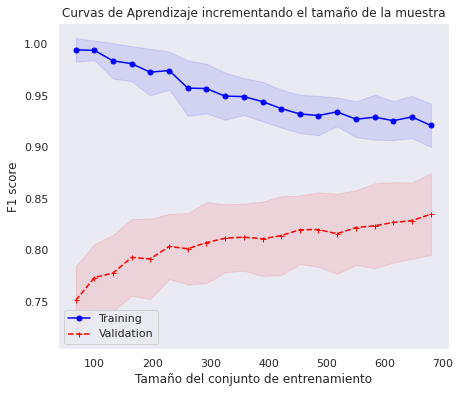

In [ ]:
mi_ModeloYCurvas_decisionTree_update(X_train, y_train, my_precision)

 Para el modelo de bosque aleatorio (random forest) realizar el entrenamiento buscando sus mejores hiperparámetros con GridSearchCV(). Los hiperparámetros que debes incluir en su búsqueda deben ser al menos los siguientes: ccp_alpha, criterion, max_depth, min_samples_split y class_weight. En este caso deberás usar la métrica (scoring) “recall”. Imprime la mejor combinación de parámetros obtenidos, así como el valor del mejor desempeño (score) obtenido con la métrica “recall”. ¿Cuál es la utilidad de la métrica “recall”? Incluye tus conclusiones.

In [ ]:
# Random forest

dicc_grid_arbol = {'ccp_alpha':[0.0],
             'criterion':['entropy', 'gini'],
             'max_depth': [5, 10],
             'min_samples_split': [2,4],
             'class_weight': ['balanced']
             }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=8)

grid = GridSearchCV(estimator=models[2], 
                    param_grid=dicc_grid_arbol, 
                    cv=cv, 
                    scoring=make_scorer(my_recall))

Xx = columnasTransformer.fit_transform(X_train)

# Llevamos a cabo el proceso de etrenamiento con validación-cruzada y búsqueda de malla.
# Observa que de acuerdo a las opciones incluidas en la malla, se estarán realizando (6)(5)=30 
# combinaciones diferentes, además de las (10)(5)=50 particiones de la validación-cruzada,
# lo cual implica también un mayor tiempo de entrenamiento.

grid.fit(Xx, np.ravel(y_train))

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=8),
             estimator=RandomForestClassifier(random_state=1),
             param_grid={'ccp_alpha': [0.0], 'class_weight': ['balanced'],
                         'criterion': ['entropy', 'gini'], 'max_depth': [5, 10],
                         'min_samples_split': [2, 4]},
             scoring=make_scorer(my_recall))

In [ ]:
print('Mejor valor de recall obtenido con la mejor combinación:', grid.best_score_)
print('Mejor combinación de valores encontrados de los hiperparámetros:', grid.best_params_)
print('Métrica utilizada:', grid.scoring)

Mejor valor de exactitud obtenido con la mejor combinación: 0.8774156163986672
Mejor combinación de valores encontrados de los hiperparámetros: {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
Métrica utilizada: make_scorer(my_recall)


Con los mejores valores de los hiperparámetros encontrados con la métrica “recall” para el modelo de bosque aleatorio, obtener las curvas de validación (validation curve), incrementando la complejidad del modelo a través del hiperparámetro “max_depth” con al menos 10 valores. Si lo crees adecuado, puedes hacer los ajustes que consideres adecuados para mejorar el resultado y evitar el sobreentrenamiento o el subentrenamiento.

In [ ]:
def mi_ModeloYCurvas_random_forest_update(X_input, Y_output, score ):
    delta_train_sz = np.linspace(0.1, 1.0, 20)
    modelo_randomForest = RandomForestClassifier(random_state=1, ccp_alpha=0.0, class_weight='balanced', criterion='gini', max_depth=10, min_samples_split=2)
    mi_pipe = Pipeline(steps = [('columnas_transformadas', columnasTransformer),('Random Forest', modelo_randomForest)])

    print('Random Forest')

    tr_sizes, tr_scores, val_scores = learning_curve(estimator = mi_pipe,    
                                                    X = X_input,
                                                    y = Y_output,
                                                    cv = cv,
                                                    train_sizes=delta_train_sz,
                                                    random_state = 11,
                                                    scoring= make_scorer(score))
  
    
    mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)

Random Forest


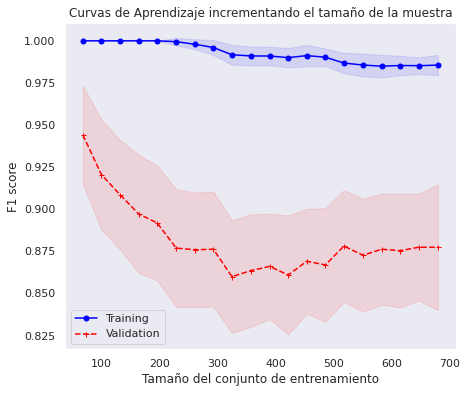

In [ ]:
mi_ModeloYCurvas_random_forest_update(X_train, y_train, my_recall)

¿Cuál es la utilidad de la métrica “f1-score”?

Es una relación armónica entre las métricas recall y precission. Esta nos ayuda a facilitar la evaluación del modelo al darnos el rendimiento combinado de ambas métricas.

¿Cuál es la utilidad de la métrica “precision”?

Con la métrica precission podemos medir la calidad del modelo. Se refiere a la dipersión del conjunto de valores obtenidos, cuanto menor sea la dispersión, mayor será la precission.

En este caso, utilizar la métrica de precision nos es útil para identificar qué proporción de las personas con créditos aprobados son buenos pagadores.


¿Cuál es la utilidad de la métrica “recall”?

Es la prporción de casos positivos que fueron correctamente identificados, y en este caso a que proporción de los buenos pagadores se les proporcionó un credito.

## Inciso 6: Modelos finales

In [ ]:
modelo = LogisticRegression(penalty='l2', C=1.0, class_weight='balanced', solver='liblinear')
clf = Pipeline(steps = [('columnas_transformadas', columnasTransformer),('Logistic Regression', modelo)])
clf.fit(X_train, y_train)
y_pred= clf.predict(X_val)
my_f1_score(y_val, y_pred)

0.7777777777777778

Para el modelo de regresión logística se observa que se obtiene una mejora con respecto del sobre entrenamiento de la evaluación de los valores utilizando los hiperparámetros en el modelo de validación. Para la evaluación del modelo final con el uso de hiperparámetros se obtiene una valor de F1 score muy cercano a la evaluación del modelo con los valores de hiperparámetro predeterminados para la función.


In [ ]:
modelo_RandomForest = DecisionTreeClassifier(random_state=1, ccp_alpha=0.0, class_weight='balanced', criterion='gini', max_depth=5, min_samples_split=4)
clf = Pipeline(steps = [('columnas_transformadas', columnasTransformer),('Decision tree', modelo_RandomForest)])
clf.fit(X_train, y_train)
y_pred= clf.predict(X_val)
my_precision(y_val, y_pred)

0.8271604938271605

El valor de precisión del modelo final que utilza los mejores hiperparametros encontrados, es muy cercano al valor de precisión obtenido en el modelo de validación. Lo que nos indica que el modelo es consistente y confiable.

In [ ]:
modelo_RandomForest = RandomForestClassifier(random_state=1, ccp_alpha=0.0, class_weight='balanced', criterion='gini', max_depth=10, min_samples_split=2)
clf = Pipeline(steps = [('columnas_transformadas', columnasTransformer),('Random Forest', modelo_RandomForest)])
clf.fit(X_train, y_train)
y_pred= clf.predict(X_val)
my_recall(y_val, y_pred)

0.8648648648648649

El valor de recall en el modelo final utilzando hiperparametros mejorados, es muy cercano al valor de recall obtenido en el modelo de validación. Lo que nos indica que el modelo es consistente y confiable.